# Analysis of Clonesig results on the TCGA
## Pancancer analysis

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import collections
from scipy.stats import chi2_contingency
from lifelines import CoxPHFitter
from pathlib import Path

pd.options.display.max_columns = 200
os.chdir('..')
output_path = '20200515_paper_figures/TCGA_results'
Path(output_path).mkdir(parents=True, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

To have a first look at data, we look how many clones were found by Clonesig for the public and protected input SNVs.

In [3]:
clonesig_res = pd.read_csv('20200214_tcga_results_survival_restr.csv', sep='\t')
clonesig_res = clonesig_res.assign(survival_days_6y=clonesig_res.survival_days)
clonesig_res = clonesig_res.assign(binary_vital_status_6y=clonesig_res.binary_vital_status)
clonesig_res = clonesig_res.assign(binary_vital_status_15y=clonesig_res.binary_vital_status)
clonesig_res = clonesig_res.assign(survival_months_15y=(clonesig_res.survival_days/30.5))


clonesig_res.loc[(clonesig_res.survival_days>=6*365)&(clonesig_res.binary_vital_status==1), 'binary_vital_status_6y'] = 0
clonesig_res.loc[clonesig_res.survival_days>=6*365, 'survival_days_6y'] = 6*365

clonesig_res.loc[(clonesig_res.survival_days>=15*365)&(clonesig_res.binary_vital_status==1), 'binary_vital_status_15y'] = 0
clonesig_res.loc[clonesig_res.survival_days>=15*365, 'survival_months_15y'] = 15*365/30.5


In [4]:
clonesig_res.patient_id.nunique()

8951

In [5]:
clonesig_res[clonesig_res.mutation_set=='public'].nb_clones.value_counts()

2    3983
1    3695
3    1027
4     208
5      29
6       8
7       1
Name: nb_clones, dtype: int64

In [6]:
clonesig_res[clonesig_res.mutation_set=='protected'].nb_clones.value_counts()

2    4568
1    2050
3    1842
4     412
5      66
6      11
7       2
Name: nb_clones, dtype: int64

Then we look at survival curves for the whole TCGA, first distinguishing 1 or 2 clones and more, then 1, 2, and 3 clones and more, and finally 1, 2 clones with no significant signature change, or 2 clones with a significant signature change, for the protected input SNVS

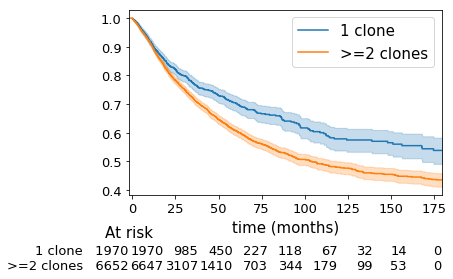

In [7]:

clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones!=1].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot()

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='>=2 clones')
ax = kmf2.plot(ax=ax)


ax.legend(fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)

add_at_risk_counts(kmf1, kmf2, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('{}/nb_clones_2_protected_survival_tcga.pdf'.format(output_path), bbox_inches='tight')


In [8]:
len(ix1) + len(ix2)

8951

In [9]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_more=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones!=1), 'two_clones_more'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_more']].to_csv('tmp/tcga_survival_one_two_clones.csv', index=False, sep='\t')


cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary




Convergence completed after 4 iterations.


coef  exp(coef)  se(coef)         z        p  lower 0.95  \
two_clones_more  0.185412   1.203714  0.047342  3.916419  0.00009    0.092603   

                 upper 0.95  
two_clones_more    0.278222

Text(0,-0.225,'At risk')

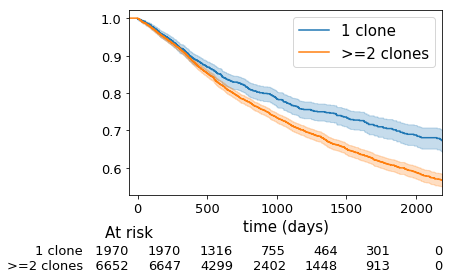

In [10]:


sns.set_context(font_scale=2.5)
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones!=1].index)

kmf1.fit(clonesig_res_all_protected.survival_days_6y[ix1], clonesig_res_all_protected.binary_vital_status_6y[ix1], label='1 clone')
ax = kmf1.plot()

kmf2.fit(clonesig_res_all_protected.survival_days_6y[ix2], clonesig_res_all_protected.binary_vital_status_6y[ix2], label='>=2 clones')
ax = kmf2.plot(ax=ax)


ax.legend(fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (days)', fontsize=15)

add_at_risk_counts(kmf1, kmf2, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)

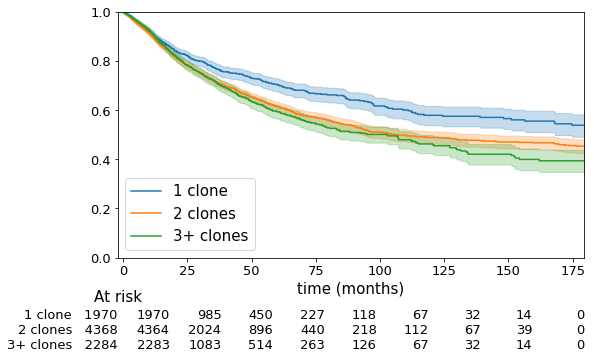

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==2].index)
ix3 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones>=3].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2 clones')
ax = kmf2.plot(ax=ax)


kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='3+ clones')
ax = kmf3.plot(ax=ax)

ax.legend(fontsize=15, loc=3)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)

add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
ax.set_ylim([0,1])
plt.savefig('{}/nb_clones_3_protected_survival_tcga.pdf'.format(output_path), bbox_inches='tight')


In [12]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_more=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2), 'two_clones'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>2), 'three_clones_more'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones', 'three_clones_more']].to_csv('tmp/tcga_survival_one_two_three_clones.csv', sep='\t', index=False)

cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones', 'three_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

df = cph.summary
df = df.assign(**{"exp(coef) lower 0.95": np.exp(df['lower 0.95']),
             "exp(coef) upper 0.95": np.exp(df['upper 0.95'])})
df


Convergence completed after 4 iterations.


coef  exp(coef)  se(coef)         z         p  \
two_clones         0.160898   1.174566  0.049711  3.236665  0.001209   
three_clones_more  0.235527   1.265575  0.055990  4.206611  0.000026   

                   lower 0.95  upper 0.95  exp(coef) lower 0.95  \
two_clones           0.063445    0.258352              1.065501   
three_clones_more    0.125765    0.345289              1.134016   

                   exp(coef) upper 0.95  
two_clones                     1.294794  
three_clones_more              1.412398

In [13]:
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[clonesig_res_all_protected.one_clone==0][['binary_vital_status_15y', 'survival_months_15y', 'three_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

df = cph.summary
df = df.assign(**{"exp(coef) lower 0.95": np.exp(df['lower 0.95']),
             "exp(coef) upper 0.95": np.exp(df['upper 0.95'])})
df



Convergence completed after 4 iterations.


coef  exp(coef)  se(coef)         z         p  \
three_clones_more  0.061631   1.063569  0.045069  1.367475  0.171477   

                   lower 0.95  upper 0.95  exp(coef) lower 0.95  \
three_clones_more   -0.026722    0.149983              0.973632   

                   exp(coef) upper 0.95  
three_clones_more              1.161815

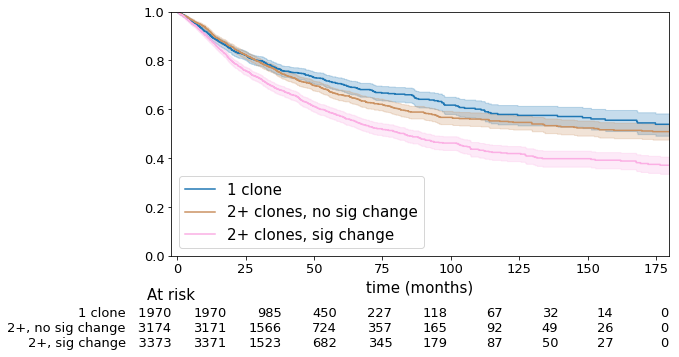

In [14]:
fig, ax = plt.subplots(figsize=(9, 5))
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05)].index)
ix3 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05)].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2+, no sig change')
ax = kmf2.plot(ax=ax, color="#CA9161")


kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='2+, sig change')
ax = kmf3.plot(ax=ax, color="#FBAFE4")

ax.legend(fontsize=15, loc=3, labels=['1 clone', '2+ clones, no sig change', '2+ clones, sig change'])
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('{}/nb_clones_2_sig_protected_survival_tcga.pdf'.format(output_path), bbox_inches='tight')


In [15]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_change=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(group='one_clone')

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05), 'two_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05), 'group'] = 'two_clones_nochange'
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05), 'two_clones_change'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05), 'group'] = 'two_clones_change'
norm_table = pd.crosstab(clonesig_res_all_protected.group, clonesig_res_all_protected.cancer_loc_x, normalize='columns').T

clonesig_res_all_protected[['patient_id', 'cancer_loc_x', 'binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change', 'group']].to_csv('tmp/tcga_survival_one_two_change_clones.csv', sep='\t', index=False)

cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_nochange', 'two_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

df = cph.summary
df = df.assign(**{"exp(coef) lower 0.95": np.exp(df['lower 0.95']),
             "exp(coef) upper 0.95": np.exp(df['upper 0.95'])})
df



Convergence completed after 4 iterations.


coef  exp(coef)  se(coef)         z         p  \
two_clones_nochange -0.059359   0.942369  0.050612 -1.172811  0.240871   
two_clones_change    0.162942   1.176969  0.049614  3.284189  0.001023   

                     lower 0.95  upper 0.95  exp(coef) lower 0.95  \
two_clones_nochange   -0.158578    0.039861              0.853356   
two_clones_change      0.065679    0.260205              1.067884   

                     exp(coef) upper 0.95  
two_clones_nochange              1.040666  
two_clones_change                1.297196

In [16]:
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[clonesig_res_all_protected.one_clone==0][['binary_vital_status_15y', 'survival_months_15y', 'two_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

df = cph.summary
df = df.assign(**{"exp(coef) lower 0.95": np.exp(df['lower 0.95']),
             "exp(coef) upper 0.95": np.exp(df['upper 0.95'])})
df



Convergence completed after 4 iterations.


coef  exp(coef)  se(coef)         z         p  \
two_clones_change  0.163365   1.177467  0.042276  3.864229  0.000111   

                   lower 0.95  upper 0.95  exp(coef) lower 0.95  \
two_clones_change    0.080487    0.246244              1.083815   

                   exp(coef) upper 0.95  
two_clones_change              1.279211

In [17]:
norm_table = pd.crosstab(clonesig_res_all_protected.group, clonesig_res_all_protected.cancer_loc_x, normalize='columns').T


clonesig_res_all_protected_m = pd.merge(clonesig_res_all_protected, norm_table.stack().to_frame(), left_on=['cancer_loc_x', 'group'], right_index=True)
clonesig_res_all_protected_m[['patient_id', 'cancer_loc_x', 'binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change', 'group', 0]].to_csv('tmp/tcga_survival_one_two_change_clones.csv', sep='\t', index=False)

clonesig_res_all_protected_m[['patient_id', 'cancer_loc_x', 'binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change', 'group', 0]].head()


patient_id cancer_loc_x  binary_vital_status_15y  survival_months_15y  \
1   TCGA-OR-A5L4          ACC                      0.0                31.77   
5   TCGA-OR-A5LE          ACC                      1.0                21.75   
7   TCGA-OR-A5KT          ACC                      0.0                95.11   
9   TCGA-OR-A5JO          ACC                      0.0                39.22   
11  TCGA-PK-A5H9          ACC                      0.0                20.24   

    one_clone  two_clones_nochange  two_clones_change                group  \
1           0                    1                  0  two_clones_nochange   
5           0                    1                  0  two_clones_nochange   
7           0                    1                  0  two_clones_nochange   
9           0                    1                  0  two_clones_nochange   
11          0                    1                  0  two_clones_nochange   

           0  
1   0.675325  
5   0.675325  
7   0.675325  
9   0.675325  
11  0.675325

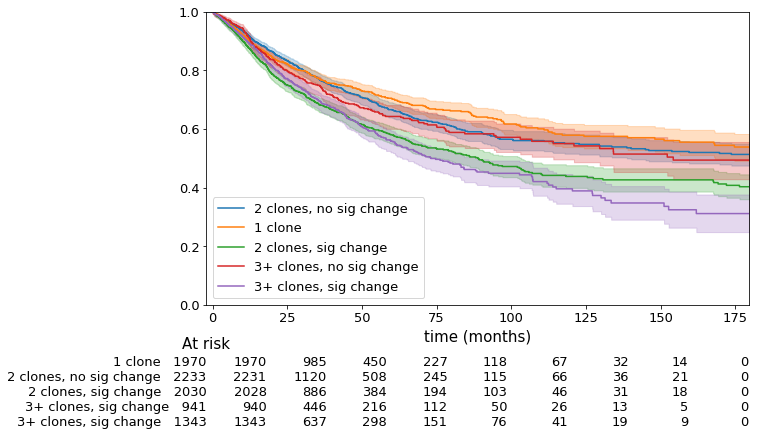

In [18]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()
kmf4 = KaplanMeierFitter()
kmf5 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval>0.05)].index)
ix3 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval<=0.05)].index)
ix4 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval>0.05)].index)
ix5 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval<=0.05)].index)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2 clones, no sig change')
ax = kmf2.plot(figsize=(10, 6))

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='2 clones, sig change')
ax = kmf3.plot(ax=ax)

kmf4.fit(clonesig_res_all_protected.survival_months_15y[ix4], clonesig_res_all_protected.binary_vital_status_15y[ix4], label='3+ clones, sig change')
ax = kmf4.plot(ax=ax)

kmf5.fit(clonesig_res_all_protected.survival_months_15y[ix5], clonesig_res_all_protected.binary_vital_status_15y[ix5], label='3+ clones, sig change')
ax = kmf5.plot(ax=ax)

#ax.legend(fontsize=13, loc=2, bbox_to_anchor=(-0.9,1.05), labels=['2 clones,\n no sig change', '1 clone', '2 clones,\n sig change', '3+ clones,\n no sig change', '3+ clones,\n sig change'])
ax.legend(fontsize=13, loc=3, labels=['2 clones, no sig change', '1 clone', '2 clones, sig change', '3+ clones, no sig change', '3+ clones, sig change'])
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, kmf4, kmf5, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('{}/nb_clones_3_sig_protected_survival_tcga.pdf'.format(output_path), bbox_inches='tight')


In [19]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_change=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_change=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval>0.05), 'two_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval<=0.05), 'two_clones_change'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval>0.05), 'three_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval<=0.05), 'three_clones_change'] = 1



#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change', 'three_clones_nochange', 'three_clones_change']].to_csv('tmp/tcga_survival_one_two_three_change_clones.csv', sep='\t', index=False)
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_nochange', 'two_clones_change', 'three_clones_nochange', 'three_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary



Convergence completed after 4 iterations.


coef  exp(coef)  se(coef)         z         p  \
two_clones_nochange   -0.087717   0.916020  0.054447 -1.611050  0.107169   
two_clones_change      0.128257   1.136845  0.055054  2.329664  0.019824   
three_clones_nochange  0.011337   1.011402  0.070476  0.160869  0.872196   
three_clones_change    0.218435   1.244128  0.061759  3.536872  0.000405   

                       lower 0.95  upper 0.95  
two_clones_nochange     -0.194455    0.019021  
two_clones_change        0.020330    0.236184  
three_clones_nochange   -0.126823    0.149498  
three_clones_change      0.097362    0.339508

Then we look at survival curves for the whole TCGA, first distinguishing 1 or 2 clones and more, then 1, 2, and 3 clones and more, and finally 1, 2 clones with no significant signature change, or 2 clones with a significant signature change, for the **public** input SNVS

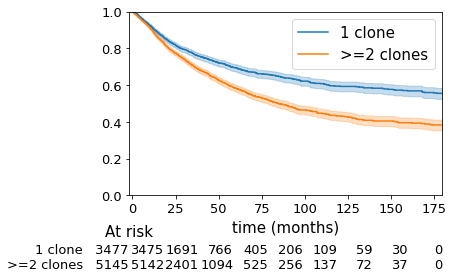

In [20]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones!=1].index)


kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot()

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='>=2 clones')
ax = kmf2.plot(ax=ax)




ax.legend(fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('{}/nb_clones_2_public_survival_tcga.pdf'.format(output_path), bbox_inches='tight')


In [21]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_more=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones!=1), 'two_clones_more'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_more']].to_csv('tmp/public_tcga_survival_one_two_clones.csv', index=False, sep='\t')
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary


Convergence completed after 4 iterations.


coef  exp(coef)  se(coef)         z             p  \
two_clones_more  0.321518    1.37922  0.039105  8.222001  2.001362e-16   

                 lower 0.95  upper 0.95  
two_clones_more    0.244858    0.398178

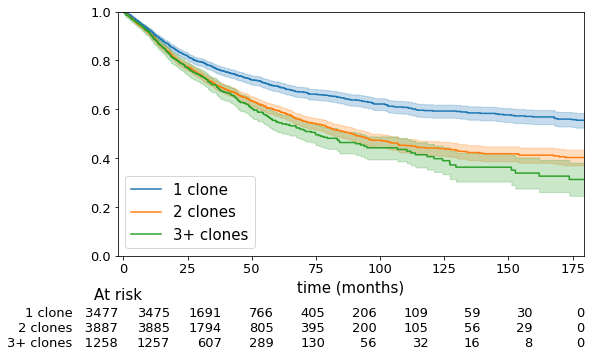

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==2].index)
ix3 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones>=3].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2 clones')
ax = kmf2.plot(ax=ax)



kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='3+ clones')
ax = kmf3.plot(ax=ax)

ax.legend(fontsize=15, loc=3)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('{}/nb_clones_3_public_survival_tcga.pdf'.format(output_path), bbox_inches='tight')


In [23]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_more=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2), 'two_clones'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>2), 'three_clones_more'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones', 'three_clones_more']].to_csv('tmp/public_tcga_survival_one_two_three_clones.csv', sep='\t', index=False)

cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones', 'three_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

df = cph.summary
df = df.assign(**{"exp(coef) lower 0.95": np.exp(df['lower 0.95']),
             "exp(coef) upper 0.95": np.exp(df['upper 0.95'])})
df


Convergence completed after 4 iterations.


coef  exp(coef)  se(coef)         z             p  \
two_clones         0.297993   1.347153  0.041367  7.203630  5.863028e-13   
three_clones_more  0.399149   1.490556  0.057563  6.934144  4.086871e-12   

                   lower 0.95  upper 0.95  exp(coef) lower 0.95  \
two_clones           0.216897    0.379089              1.242217   
three_clones_more    0.286303    0.511995              1.331496   

                   exp(coef) upper 0.95  
two_clones                     1.460953  
three_clones_more              1.668616

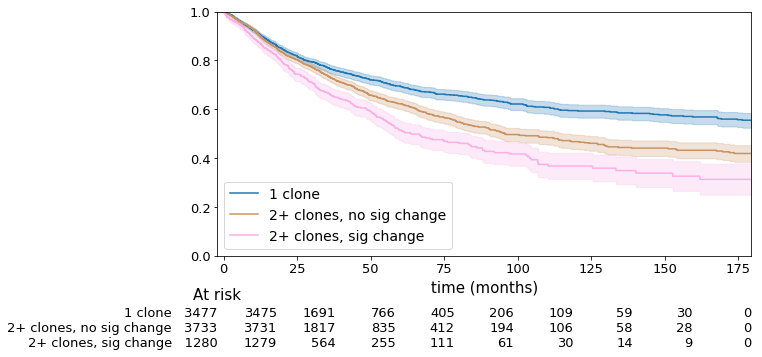

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05)].index)
ix3 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05)].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2+ clones, no sig change')
ax = kmf2.plot(ax=ax, color="#CA9161")


kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='2+ clones, sig change')
ax = kmf3.plot(ax=ax, color="#FBAFE4")

ax.legend(fontsize=14, loc=3, labels=['1 clone', '2+ clones, no sig change', '2+ clones, sig change'])
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('{}/nb_clones_2_sig_public_survival_tcga.pdf'.format(output_path), bbox_inches='tight')


In [25]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_change=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05), 'two_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05), 'two_clones_change'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change']].to_csv('tmp/public_tcga_survival_one_two_change_clones.csv', sep='\t', index=False)
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_nochange', 'two_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

df = cph.summary
df = df.assign(**{"exp(coef) lower 0.95": np.exp(df['lower 0.95']),
             "exp(coef) upper 0.95": np.exp(df['upper 0.95'])})
df



Convergence completed after 5 iterations.


coef  exp(coef)  se(coef)         z             p  \
two_clones_nochange  0.129112   1.137817  0.041270  3.128483  1.757113e-03   
two_clones_change    0.387801   1.473737  0.056316  6.886157  5.731974e-12   

                     lower 0.95  upper 0.95  exp(coef) lower 0.95  \
two_clones_nochange    0.048207    0.210017              1.049388   
two_clones_change      0.277400    0.498203              1.319694   

                     exp(coef) upper 0.95  
two_clones_nochange              1.233699  
two_clones_change                1.645761

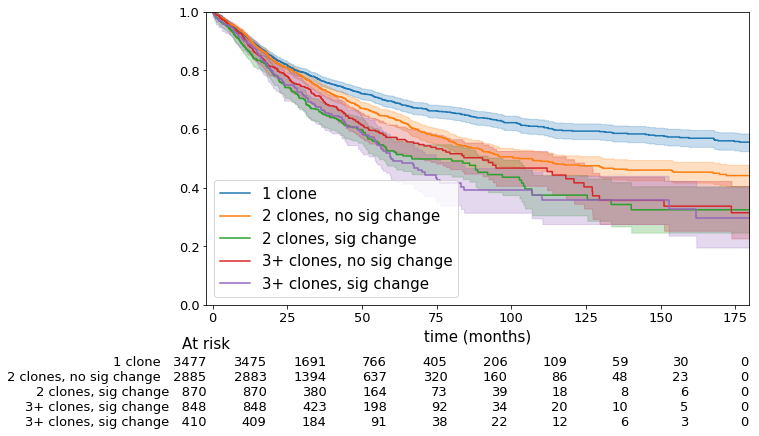

In [26]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()
kmf4 = KaplanMeierFitter()
kmf5 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval>0.05)].index)
ix3 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval<=0.05)].index)
ix4 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval>0.05)].index)
ix5 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval<=0.05)].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(figsize=(10, 6))

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2 clones, no sig change')
ax = kmf2.plot(ax=ax)



kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='2 clones, sig change')
ax = kmf3.plot(ax=ax)

kmf4.fit(clonesig_res_all_protected.survival_months_15y[ix4], clonesig_res_all_protected.binary_vital_status_15y[ix4], label='3+ clones, sig change')
ax = kmf4.plot(ax=ax)

kmf5.fit(clonesig_res_all_protected.survival_months_15y[ix5], clonesig_res_all_protected.binary_vital_status_15y[ix5], label='3+ clones, sig change')
ax = kmf5.plot(ax=ax)

ax.legend(fontsize=15, loc=3, labels=['1 clone', '2 clones, no sig change', '2 clones, sig change', '3+ clones, no sig change', '3+ clones, sig change'])
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, kmf4, kmf5, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('{}/nb_clones_3_sig_public_survival_tcga.pdf'.format(output_path), bbox_inches='tight')


In [27]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_change=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_change=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval>0.05), 'two_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval<=0.05), 'two_clones_change'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval>0.05), 'three_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval<=0.05), 'three_clones_change'] = 1



#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change', 'three_clones_nochange', 'three_clones_change']].to_csv('tmp/public_tcga_survival_one_two_three_change_clones.csv', sep='\t', index=False)
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_nochange', 'two_clones_change', 'three_clones_nochange', 'three_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary



Convergence completed after 5 iterations.


coef  exp(coef)  se(coef)         z             p  \
two_clones_nochange    0.086903   1.090791  0.044173  1.967327  4.914553e-02   
two_clones_change      0.391893   1.479779  0.066193  5.920415  3.211298e-09   
three_clones_nochange  0.286439   1.331677  0.067177  4.263939  2.008545e-05   
three_clones_change    0.385195   1.469901  0.086384  4.459085  8.231038e-06   

                       lower 0.95  upper 0.95  
two_clones_nochange      0.000306    0.173500  
two_clones_change        0.262127    0.521658  
three_clones_nochange    0.154745    0.418132  
three_clones_change      0.215848    0.554542

Now, one more exploration to see if the difference in survival is found in a cancer-type-specific way. It is not, maybe a problem of sample size and statistical power or Simpson's paradox

## Cancer-type specific survival analysis

ACC
4 52 21
BLCA
77 84 192
BRCA
165 427 338
CESC
38 51 186
CHOL
6 22 7
COADREAD
54 73 330
DLBC
10 11 16
ESCA
40 49 91
GBM
35 47 140
HNSC
121 190 134
KICH
2 15 43
KIRC
62 162 47
KIRP
43 109 90
LGG
73 305 77
LIHC
64 156 127
LUAD
103 116 214
LUSC
132 56 235
MESO
24 40 14
OV
7 163 220
PAAD
56 71 23
PCPG
40 96 5
PRAD
166 226 66
SARC
21 105 84
SKCM
98 123 203
STAD
97 142 179
TGCT
57 61 10
THCA
301 137 29
THYM
61 28 32
UCEC
83 167 236
UCS
2 11 40
UVM
8 48 24


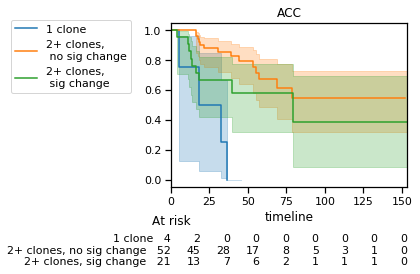

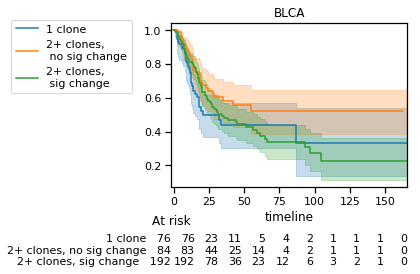

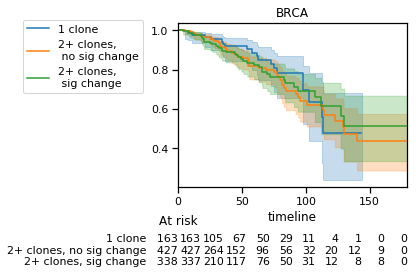

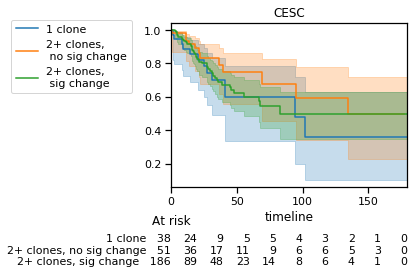

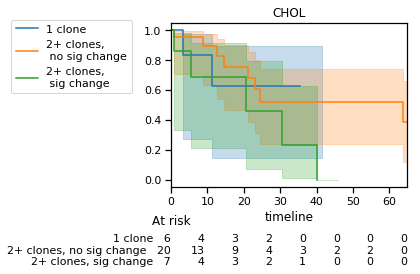

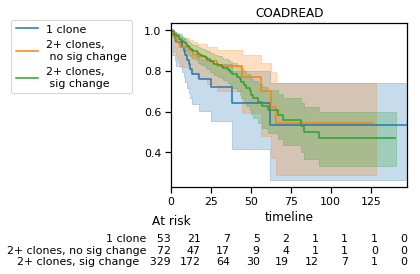

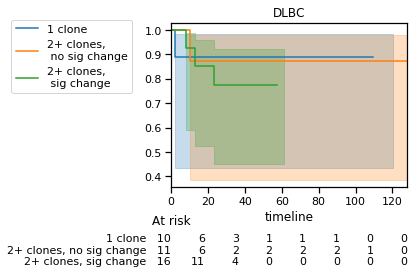

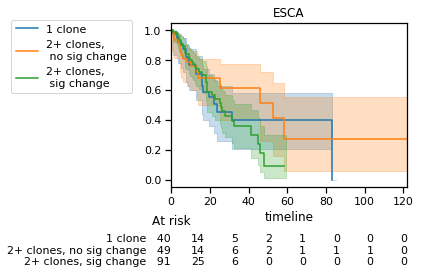

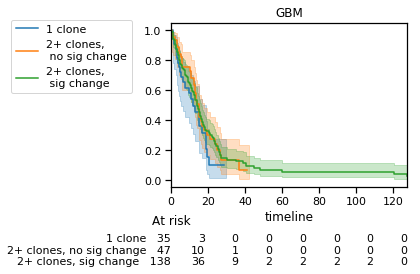

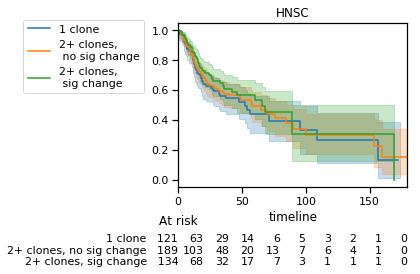

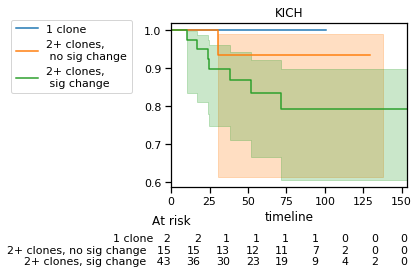

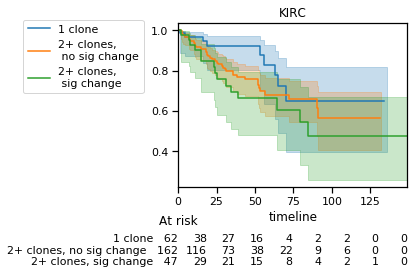

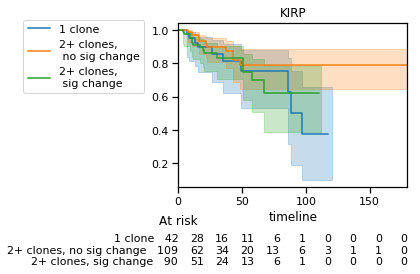

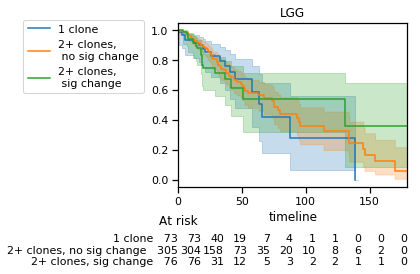

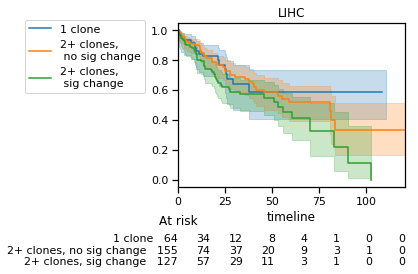

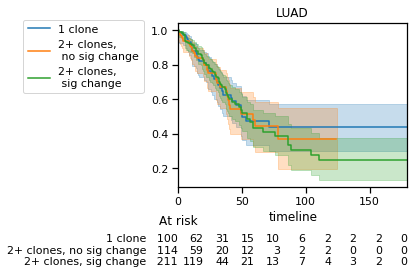

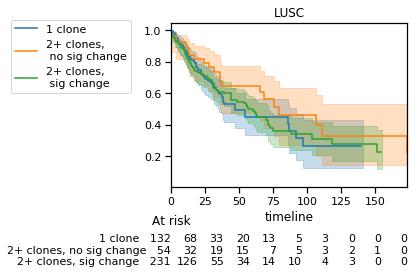

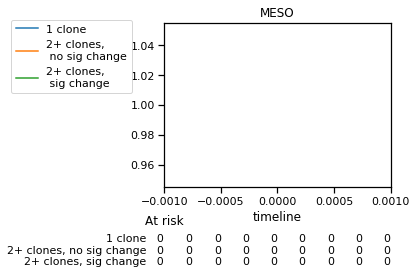

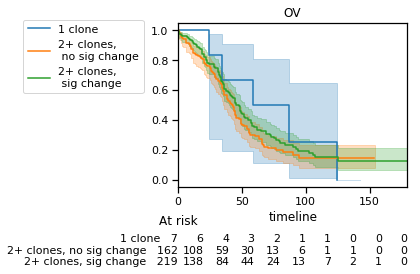

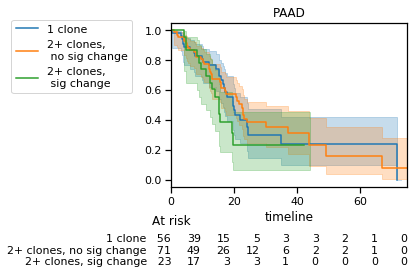

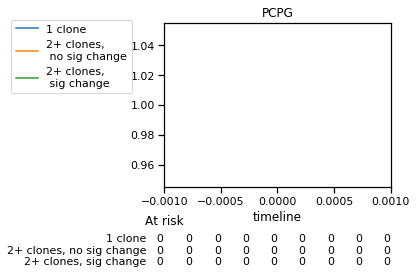

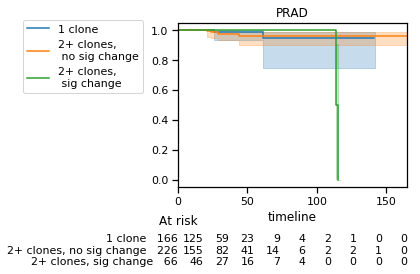

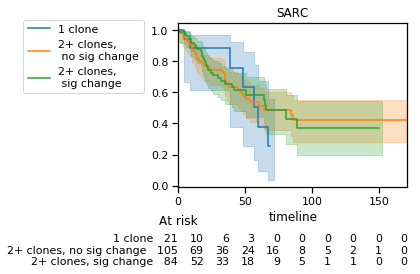

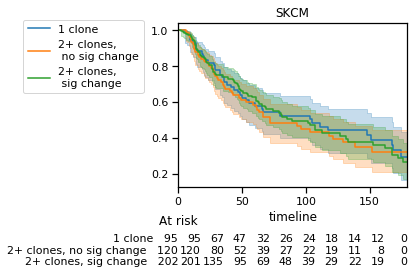

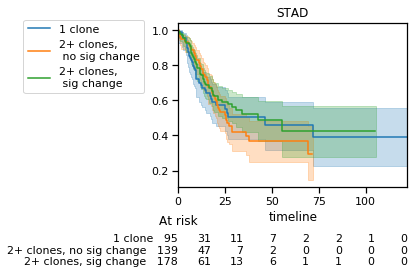

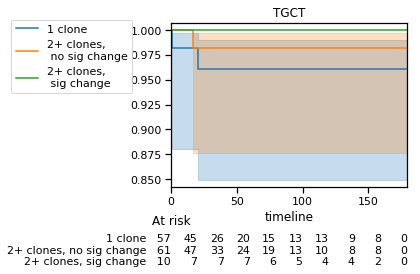

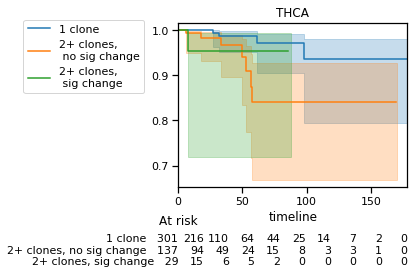

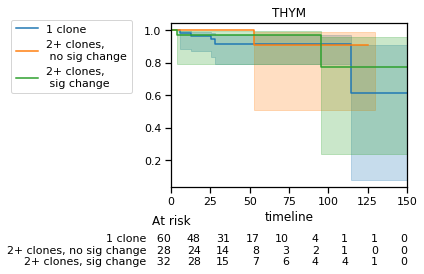

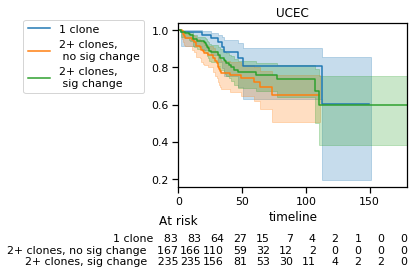

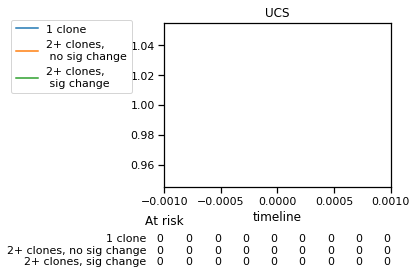

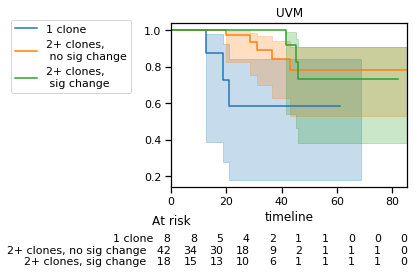

In [28]:
import lifelines
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
sns.set_context('notebook')
for loc in clonesig_res_all_protected.cancer_loc_x.unique():
    print(loc)
    try:
        figure = plt.figure()
        restr_loc = clonesig_res_all_protected[clonesig_res_all_protected.cancer_loc_x==loc]
        kmf1 = KaplanMeierFitter()
        kmf2 = KaplanMeierFitter()
        kmf3 = KaplanMeierFitter()

        ix1 = (restr_loc[restr_loc.nb_clones==1].index)
        ix2 = (restr_loc[(restr_loc.nb_clones!=1) &(restr_loc.pval>0.05)].index)
        ix3 = (restr_loc[(restr_loc.nb_clones!=1) &(restr_loc.pval<=0.05)].index)
        print(len(ix1), len(ix2), len(ix3))
        kmf1.fit(restr_loc.survival_months_15y[ix1], restr_loc.binary_vital_status_15y[ix1], label='1 clone')
        ax=kmf1.plot()

        kmf2.fit(restr_loc.survival_months_15y[ix2], restr_loc.binary_vital_status_15y[ix2], label='2+ clones, no sig change')
        ax=kmf2.plot(ax=ax)



        kmf3.fit(restr_loc.survival_months_15y[ix3], restr_loc.binary_vital_status_15y[ix3], label='2+ clones, sig change')
        ax=kmf3.plot(ax=ax)
        



        from lifelines.plotting import add_at_risk_counts
        add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
        ax.legend(fontsize=11, loc=2, bbox_to_anchor=(-0.7,1.05), labels=['1 clone', '2+ clones,\n no sig change', '2+ clones,\n sig change'])
        ax.set_title(loc)
    except:
        print('not enough for', loc)

In [29]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(group='1 clone')

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones!=1) &(clonesig_res_all_protected.pval>0.05), 'group'] = '2+ clones, no sig change'
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones!=1) &(clonesig_res_all_protected.pval<=0.05), 'group'] = '2+ clones, sig change'

In [30]:
clonesig_res_all_protected.pivot_table(index='cancer_loc_x', columns='group', values='nb_clones', aggfunc='count')

group         1 clone  2+ clones, no sig change  2+ clones, sig change
cancer_loc_x                                                          
ACC                 4                        52                     21
BLCA               77                        84                    192
BRCA              165                       427                    338
CESC               38                        51                    186
CHOL                6                        22                      7
COADREAD           54                        73                    330
DLBC               10                        11                     16
ESCA               40                        49                     91
GBM               140                        47                    140
HNSC              121                       190                    134
KICH                2                        15                     43
KIRC               62                       162                     47
KIRP               43                       109                     90
LGG                73                       305                     77
LIHC               64                       156                    127
LUAD              103                       116                    214
LUSC              132                        56                    235
MESO               24                        40                     14
OV                  7                       163                    220
PAAD               56                        71                     23
PCPG               40                        96                      5
PRAD              166                       226                     66
SARC               21                       105                     84
SKCM               98                       123                    203
STAD               97                       142                    179
TGCT               57                        61                     10
THCA              301                       137                     29
THYM               61                        28                     32
UCEC               83                       167                    236
UCS                 2                        11                     40
UVM                 8                        48                     24

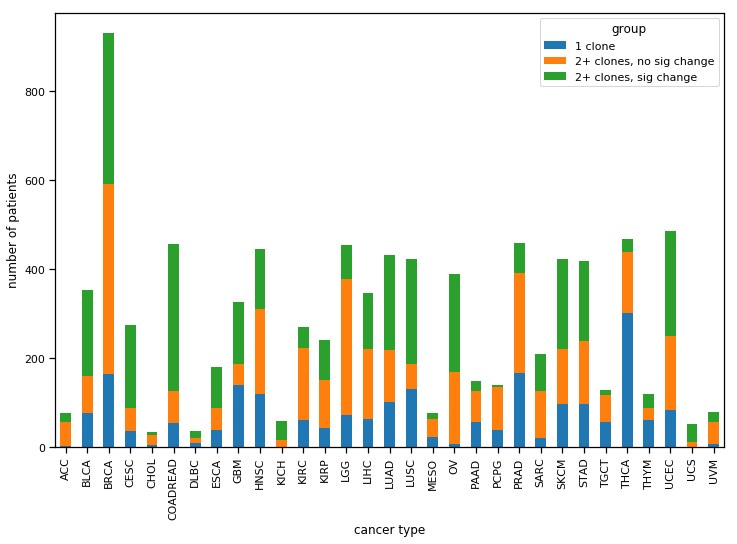

In [31]:

ax=clonesig_res_all_protected.pivot_table(index='cancer_loc_x', columns='group', values='nb_clones', aggfunc='count').plot.bar(stacked=True, figsize=(12, 8))
ax.set_ylabel('number of patients')
ax.set_xlabel('cancer type')
plt.savefig('{}/overview_cancertype_repartition.pdf'.format(output_path), bbox_inches='tight')


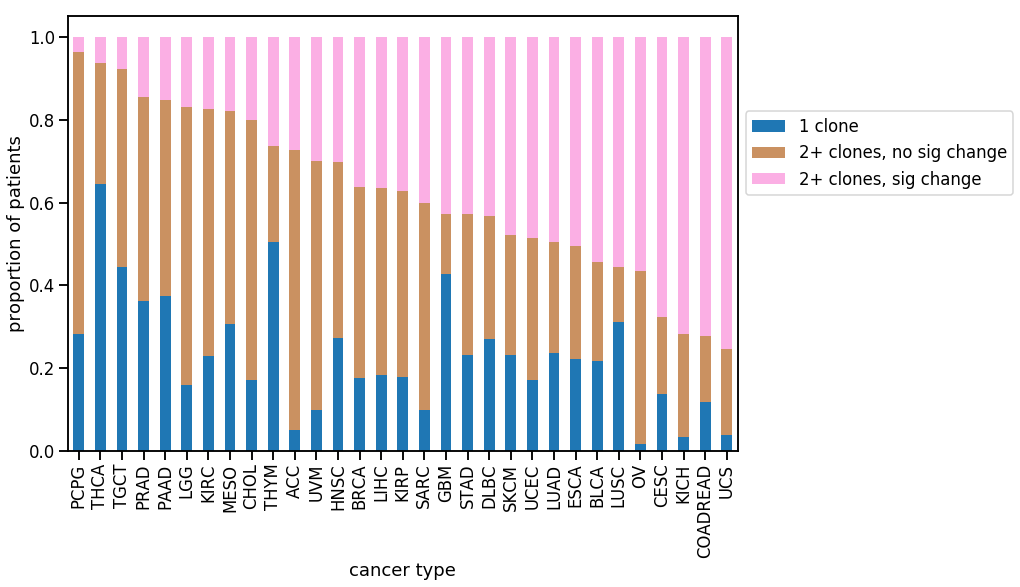

In [32]:
sns.set_context('talk')
norm_table = pd.crosstab(clonesig_res_all_protected.group, clonesig_res_all_protected.cancer_loc_x, normalize='columns').T.sort_values(by='2+ clones, sig change')
colors = ['#1f77b4', "#CA9161", "#FBAFE4"]
customPalette = sns.set_palette(sns.color_palette(colors))

ax=norm_table.plot.bar(stacked=True, figsize=(12, 8), colors=customPalette, alpha=1)
ax.set_ylabel('proportion of patients')
ax.set_xlabel('cancer type')
ax.legend(loc=2, bbox_to_anchor=(1, 0.8))
plt.savefig('{}/overview_cancertype_repartition_norm.pdf'.format(output_path), bbox_inches='tight')


In [33]:
clonesig_res_all_protected.pivot_table(index='cancer_loc_x', columns='group', values='binary_vital_status', aggfunc='count')


group         1 clone  2+ clones, no sig change  2+ clones, sig change
cancer_loc_x                                                          
ACC                 4                        52                     21
BLCA               76                        84                    192
BRCA              163                       427                    338
CESC               38                        51                    186
CHOL                6                        20                      7
COADREAD           53                        72                    329
DLBC               10                        11                     16
ESCA               40                        49                     91
GBM               140                        47                    138
HNSC              121                       189                    134
KICH                2                        15                     43
KIRC               62                       162                     47
KIRP               42                       109                     90
LGG                73                       305                     76
LIHC               64                       155                    127
LUAD              100                       114                    211
LUSC              132                        54                    231
MESO                0                         0                      0
OV                  7                       162                    219
PAAD               56                        71                     23
PCPG                0                         0                      0
PRAD              166                       226                     66
SARC               21                       105                     84
SKCM               95                       120                    202
STAD               95                       139                    178
TGCT               57                        61                     10
THCA              301                       137                     29
THYM               60                        28                     32
UCEC               83                       167                    235
UCS                 0                         0                      0
UVM                 8                        42                     18

In [34]:
clonesig_res_all_protected.groupby("group").binary_vital_status.sum()

group
1 clone                      557.0
2+ clones, no sig change     861.0
2+ clones, sig change       1100.0
Name: binary_vital_status, dtype: float64

In [35]:
clonesig_res_all_protected.groupby("group").binary_vital_status.count()

group
1 clone                     2075
2+ clones, no sig change    3174
2+ clones, sig change       3373
Name: binary_vital_status, dtype: int64

And finally an overview of which signatures change the most in each cancer type
## Signature change trends by cancer type

ACC
BLCA
BRCA
CESC
CHOL
COADREAD
DLBC
ESCA
GBM
HNSC
KICH
KIRC
KIRP
LGG
LIHC
LUAD
LUSC
MESO
OV
PAAD
PCPG
PRAD
SARC
SKCM
STAD
TGCT
THCA
THYM
UCEC
UCS
UVM


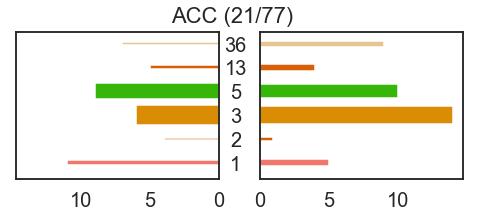

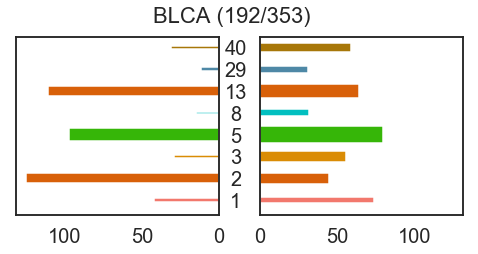

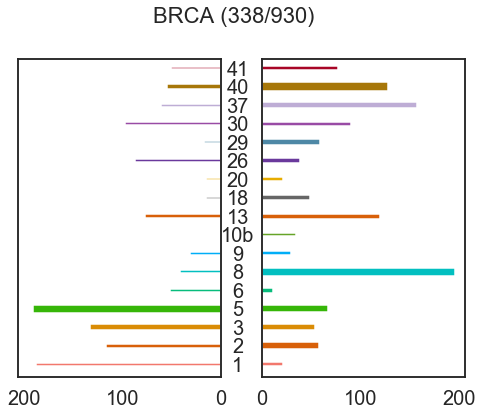

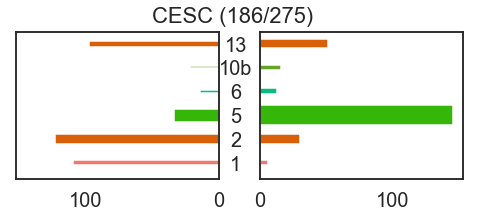

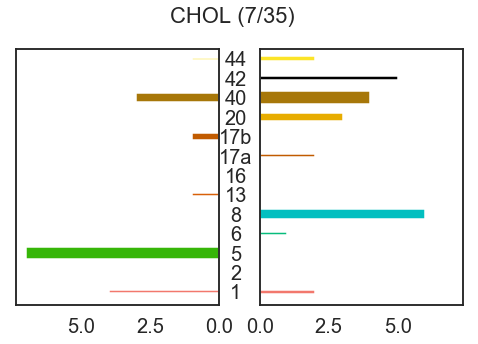

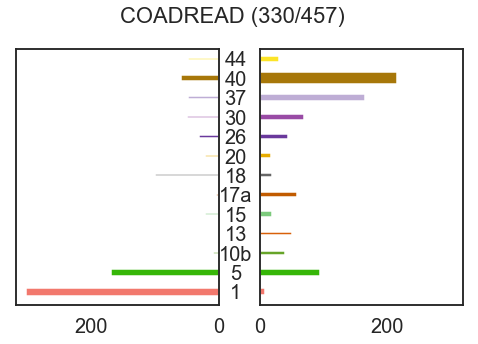

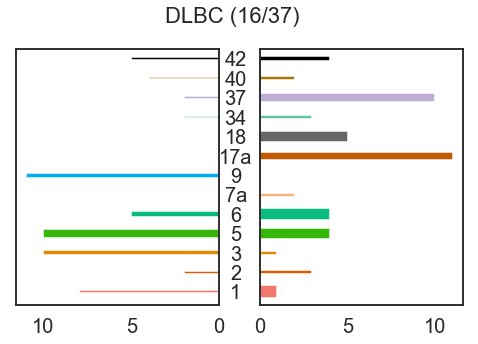

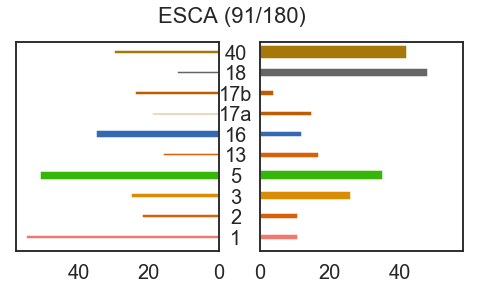

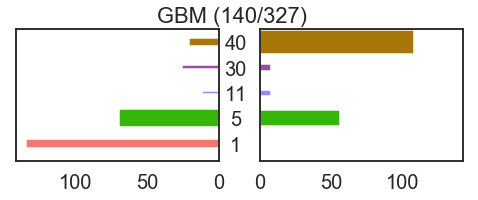

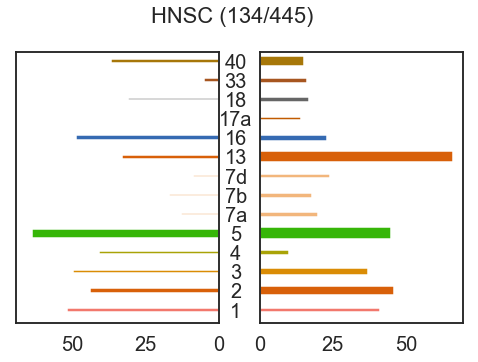

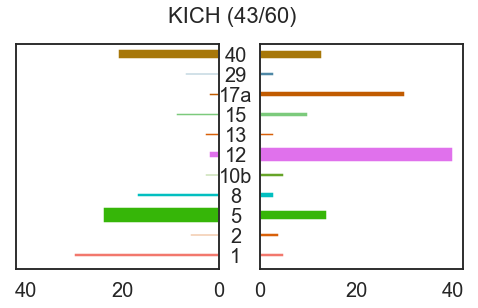

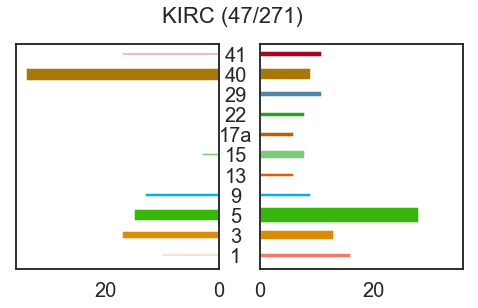

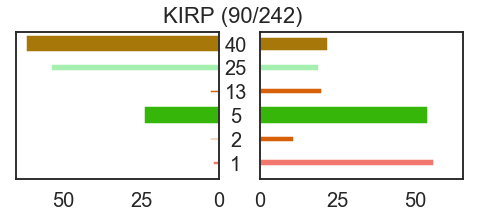

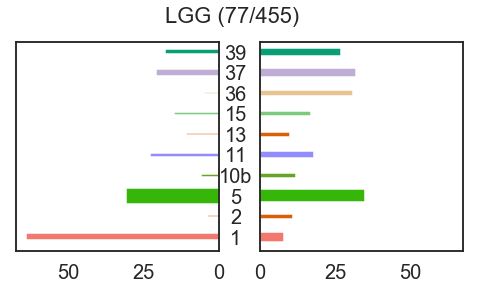

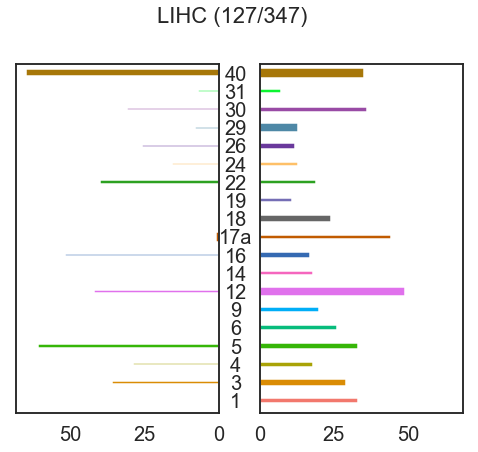

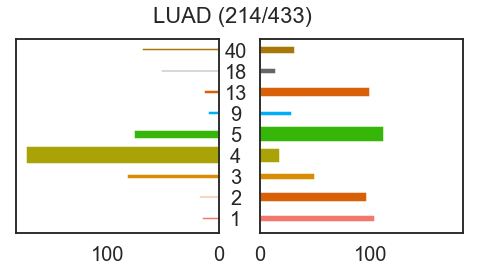

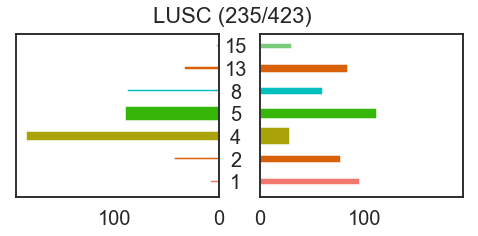

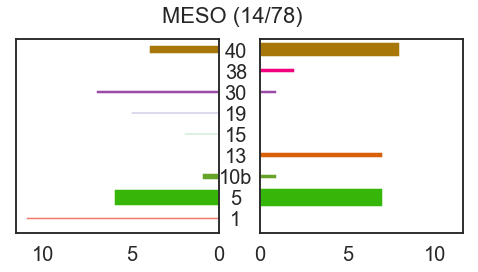

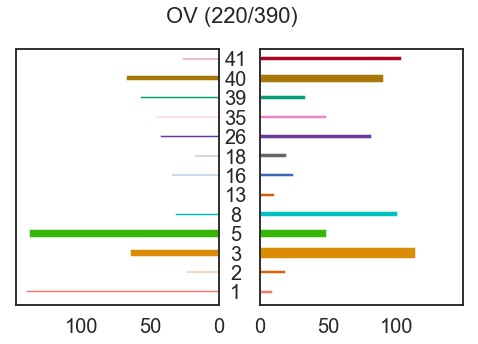

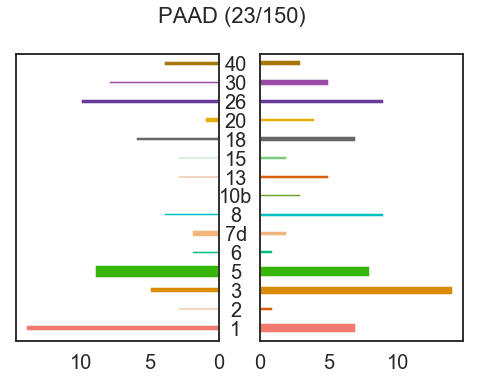

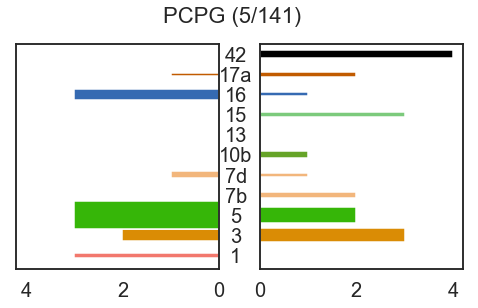

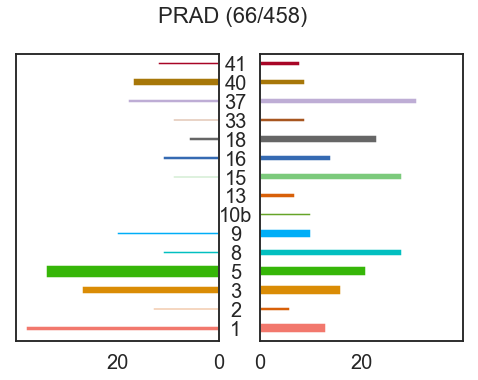

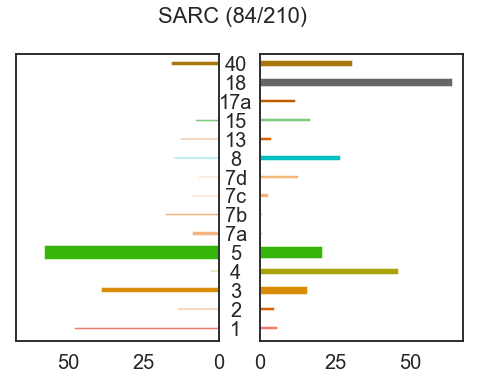

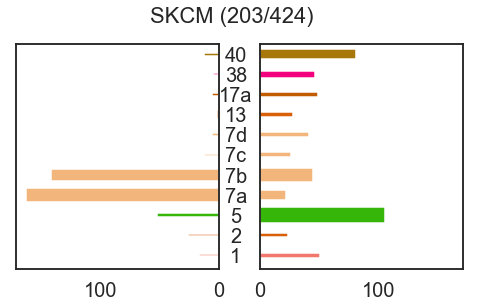

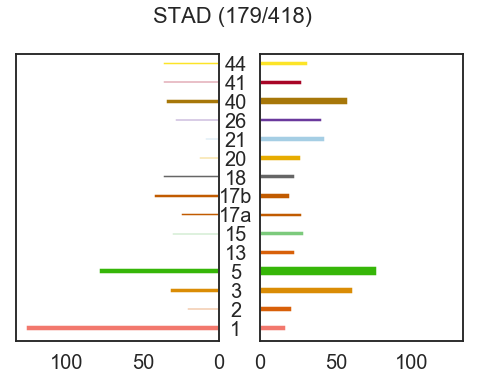

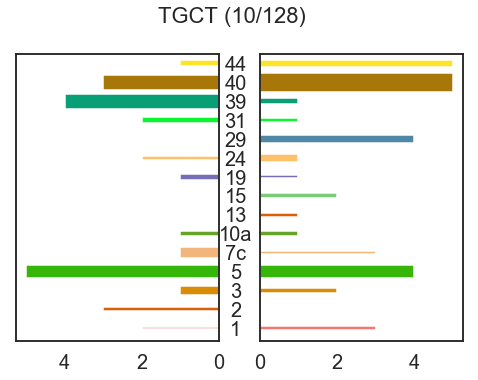

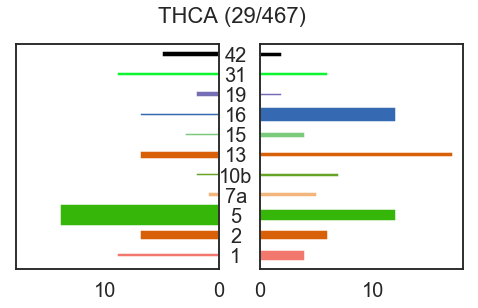

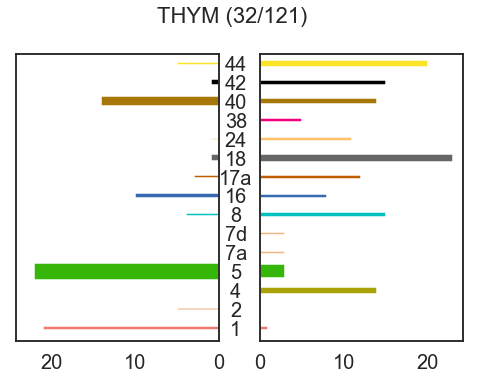

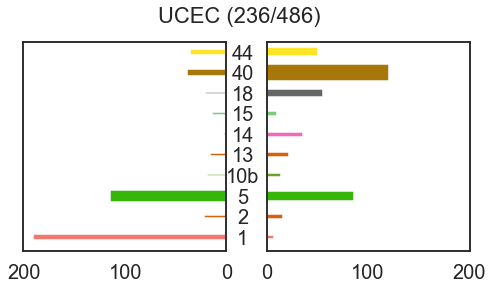

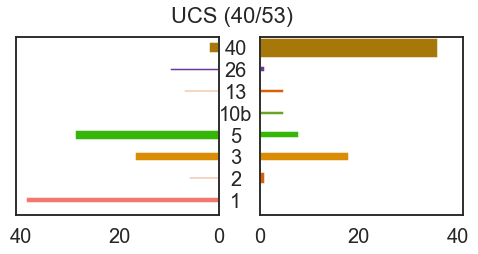

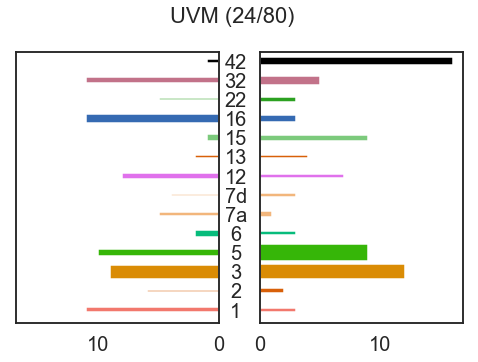

In [36]:
color_dict = collections.OrderedDict()
color_dict['SBS1']= '#F2786D'
color_dict['SBS2']= '#D86009'
color_dict['SBS13']= '#D86009'
color_dict['SBS3']= '#DA8C05'
color_dict['SBS4']= '#A9A307'
color_dict['SBS5']= '#36B608'
color_dict['SBS6']= '#07BC7C'
color_dict['SBS7a']= '#f2b67c'
color_dict['SBS7b']= '#f2b67c'
color_dict['SBS7c']= '#f2b67c'
color_dict['SBS7d']= '#f2b67c'
color_dict['SBS8']= '#02BFC0'
color_dict['SBS9']= '#00AEF7'
color_dict['SBS10a']= '#66A428'
color_dict['SBS10b']= '#66A428'
color_dict['SBS11']= '#938CFF'
color_dict['SBS12']= '#E071EC'
color_dict['SBS14']= '#F566BE'
color_dict['SBS15']= '#7CCA7C'
color_dict['SBS16']= '#356AB2'
color_dict['SBS17a']= '#C15B00'
color_dict['SBS17b']= '#C15B00'
color_dict['SBS18']= '#666666'
color_dict['SBS19']= '#756EB5'
color_dict['SBS20']= '#E7AC00'
color_dict['SBS21']= '#A5CEE4'
color_dict['SBS22']= '#2CA121'
color_dict['SBS23']= '#335a9c'
color_dict['SBS24']= '#FEC068'
color_dict['SBS25']= '#a5f0b1'
color_dict['SBS26']= '#6A399C'
color_dict['SBS28']= '#E71408'
color_dict['SBS29']= '#4e88a6'
color_dict['SBS30']= '#994BA5'
color_dict['SBS31']= '#0cf531'
color_dict['SBS32']= '#c27289'
color_dict['SBS33']= '#A75620'
color_dict['SBS34']= '#62C3A4'
color_dict['SBS35']= '#E988C4'
color_dict['SBS36']= '#E6C591'
color_dict['SBS37']= '#BEADD5'
color_dict['SBS38']= '#F3007E'
color_dict['SBS39']= '#089F76'
color_dict['SBS40']= '#A77709'
color_dict['SBS41']= '#a80526'
color_dict['SBS42']= 'black'
color_dict['SBS43']= '#6b088a'
color_dict['SBS44']= '#fce428'
color_dict['SBS45']= '#f0d0f2'
color_dict['SBS46']= '#78aaff'
color_dict['SBS47']= '#ffb108'
color_dict['SBS49']= '#c108ff'
color_dict['SBS54']= '#1320d1'
color_dict['SBS56']= '#e8dba2'
color_dict['SBS58']= '#b0eb31'
color_dict['SBS27']= '#b8b8b8'
used_sigs = list()
sns.set_style('white')
for loc in clonesig_res.cancer_loc_x.unique():
    print(loc)
    sub_protected_chg = clonesig_res[(clonesig_res.mutation_set=='protected')&(clonesig_res.pval<0.05) & (clonesig_res.cancer_loc_x==loc)]#&(clonesig_res.nb_mut>200)&(clonesig_res.purity>0.4)]
    sbs_names = [c.split('_')[1] for c in sub_protected_chg if 'subclonal_SBS' in c]
    bla = pd.DataFrame(sub_protected_chg[[c for c in sub_protected_chg if 'subclonal_SBS' in c]].fillna(0).values - sub_protected_chg[[c for c in sub_protected_chg if ('clonal_SBS' in c) and ("sub" not in c)]].fillna(0).values, columns=sbs_names)

    final_table = bla[[c for i, c in enumerate(bla.columns) if np.abs(bla).sum(axis=0)[c]>0]]
    final_table[np.abs(final_table)<0.05] = 0
    final_table = final_table[[c for i, c in enumerate(final_table.columns) if np.abs(final_table!=0).sum(axis=0)[c]>0.1*len(final_table)]]
    (final_table>0).sum(axis=0)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, final_table.shape[1]/3.5+1))
    plt.subplots_adjust(wspace = 0.2)
    axes[1].barh(y=np.arange(final_table.shape[1]), width=(final_table>0).sum(axis=0).to_frame().T.values[0], color=[color_dict[c] for c in (final_table>0).sum(axis=0).to_frame().T.columns], height= final_table[final_table>0].median(axis=0)*2+0.05)
    axes[0].barh(y=np.arange(final_table.shape[1]), width=(final_table<0).sum(axis=0).to_frame().T.values[0], color=[color_dict[c] for c in (final_table<0).sum(axis=0).to_frame().T.columns],  height= final_table[final_table<0].median(axis=0)*2+0.05)
    axes[0].invert_xaxis()

    fig.suptitle('{} ({}/{})'.format(sub_protected_chg.cancer_loc_x.unique()[0], len(sub_protected_chg), len(clonesig_res[(clonesig_res.mutation_set=='protected') & (clonesig_res.cancer_loc_x==loc)])), fontsize=22,y=1 + 0.05/final_table.shape[1])
    axes[1].set_yticks(range(len(final_table.columns)))
    axes[1].get_yaxis().set_tick_params(pad=15)
    used_sigs += final_table.columns.tolist()
    axes[1].set_yticklabels([c.replace('SBS', '') for c in final_table.columns.tolist()], fontsize=20, ha='center')
    axes[0].set_ylim([-0.7, final_table.shape[1]-0.5])
    axes[1].set_ylim([-0.7, final_table.shape[1]-0.5])
    axes[0].set_yticks([])
    axes[1].tick_params(axis="x", labelsize=20)
    axes[0].tick_params(axis="x", labelsize=20)
    max_x = max([axes[1].get_xlim()[1], axes[0].get_xlim()[0]])
    axes[0].set_xlim([max_x, 0])
    axes[1].set_xlim([0, max_x])
    plt.savefig('{}/{}_sig_trend.pdf'.format(output_path, loc), bbox_inches='tight')


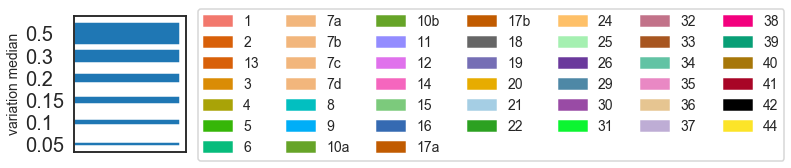

In [37]:

plt.figure(figsize=(2,6.0/4+1))
plt.barh(y=np.arange(6), width=[5]*6 , height=np.array([0.05, 0.1, 0.15, 0.2, 0.3, 0.5]) *2+0.05)
#axes[0].barh(y=np.arange(final_table.shape[1]), width=(final_table<0).sum(axis=0).to_frame().T.values[0], color=[color_dict[c] for c in (final_table<0).sum(axis=0).to_frame().T.columns],  height= final_table[final_table<0].median(axis=0)+0.05)
plt.gca().get_yaxis().set_tick_params(pad=40)
plt.gca().set_yticks(range(6))
plt.gca().set_yticklabels([str(np.round(i, 2)) for i in [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]], fontsize=20, ha='left')
plt.gca().set_xticklabels([])
plt.gca().set_ylabel('variation median', fontsize=14)

patchList = []
for key in color_dict.keys():
        if key in used_sigs:
            data_key = Patch(color=color_dict[key], label=key.replace('SBS', ''))
            patchList.append(data_key)

plt.legend(handles=patchList, loc=2, bbox_to_anchor=(1.05, 1.1), ncol=7, fontsize=14)
plt.savefig('{}/legend_sig_trend.pdf'.format(output_path, loc), bbox_inches='tight')


In [38]:
sub_protected_chg.head()

patient_id mutation_set cancer_loc_x   cosmic_type  prop_diploid  \
17743  TCGA-VD-A8K9    protected          UVM  Eye-Melanoma           0.0   
17747  TCGA-WC-AA9A    protected          UVM  Eye-Melanoma           0.0   
17753  TCGA-VD-AA8S    protected          UVM  Eye-Melanoma           0.0   
17755  TCGA-VD-AA8T    protected          UVM  Eye-Melanoma           0.0   
17759  TCGA-V4-A9EF    protected          UVM  Eye-Melanoma           0.0   

         ploidy  purity  nb_mut  nb_sigs  nb_sigs_prefit  major_cn_mean  \
17743  2.151711    0.94      87       14              14       1.126437   
17747  1.880165    0.88      83       14              14       1.024096   
17753  2.298192    1.00      58       14              14       1.362069   
17755  1.944310    0.87      84       14              14       1.035714   
17759  2.046171    0.80      91       14              14       1.153846   

       total_cn_mean    method  prefit_bool  sigprofiler_bool  dof  nb_clones  \
17743       2.114943  clonesig        False             False    7          2   
17747       1.843373  clonesig        False             False    7          2   
17753       2.275862  clonesig        False             False    7          2   
17755       1.964286  clonesig        False             False    7          2   
17759       2.021978  clonesig        False             False    7          2   

              lr      pval  clonal_phi  clonal_xi  nb_mut_clonal  \
17743  14.746223  0.008393    0.999990   0.529997             42   
17747  11.586943  0.031073    0.999990   0.463756             37   
17753  10.382749  0.049615    0.955577   0.419024             22   
17755  20.504373  0.000687    0.965702   0.550140             45   
17759  10.824668  0.042469    0.999990   0.446334             38   

       largest_subclonal_phi  largest_subclonal_xi  nb_mut_largest_subclonal  \
17743               0.318409              0.470003                      45.0   
17747               0.286040              0.536244                      46.0   
17753               0.303392              0.580976                      36.0   
17755               0.265745              0.449860                      39.0   
17759               0.303256              0.553666                      53.0   

       clonal_largest_sub_pidist  largest_pi_dist  overall_profile_dist  \
17743                   0.204328         0.204328              0.105723   
17747                   0.161088         0.161088              0.094847   
17753                   0.527615         0.527615              0.145641   
17755                   0.486164         0.486164              0.113974   
17759                   0.309840         0.309840              0.124365   

         runtime   clonal_SBS1   clonal_SBS2  clonal_SBS3  clonal_SBS4  \
17743   8.859552  2.811761e-17  8.607007e-02     0.002638          NaN   
17747  11.620339  2.120426e-01  1.868894e-90     0.581806          NaN   
17753  10.083798  2.819401e-28  5.079221e-32     0.471380          NaN   
17755   6.021122  1.839361e-01  1.272893e-01     0.354938          NaN   
17759  19.778084  2.989098e-01  1.388348e-03     0.021401          NaN   

       clonal_SBS5   clonal_SBS6  clonal_SBS7a  clonal_SBS7b  clonal_SBS7c  \
17743     0.692079  6.185231e-09  2.477004e-18           NaN           NaN   
17747     0.000309  9.591113e-12  2.496475e-02           NaN           NaN   
17753     0.015627  3.587645e-46  1.036391e-01           NaN           NaN   
17755     0.014193  2.479736e-16  3.705162e-33           NaN           NaN   
17759     0.254228  1.056794e-16  3.106015e-31           NaN           NaN   

       clonal_SBS7d  clonal_SBS8  clonal_SBS9  clonal_SBS10a  clonal_SBS10b  \
17743  3.233767e-12          NaN          NaN            NaN            NaN   
17747  1.750195e-21          NaN          NaN            NaN            NaN   
17753  2.104102e-55          NaN          NaN            NaN            NaN   
17755  2.355868e-06          NaN     

ACC
BLCA
BRCA
CESC
CHOL
COADREAD
DLBC
ESCA
GBM
HNSC
KICH
KIRC
KIRP
LGG
LIHC
LUAD
LUSC
MESO
OV
PAAD
PCPG
PRAD
SARC
SKCM
STAD
TGCT
THCA
THYM
UCEC
UCS
UVM


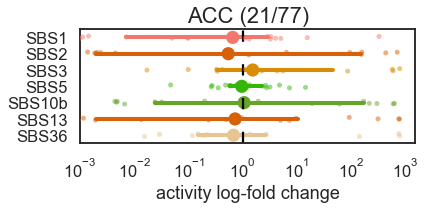

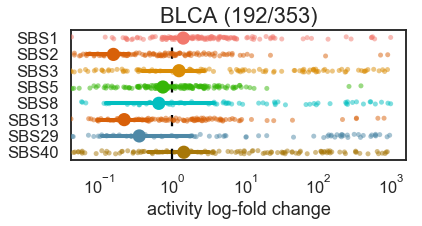

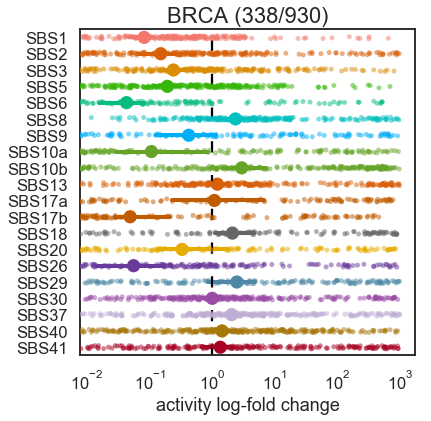

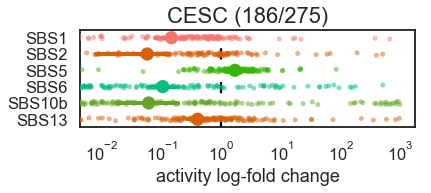

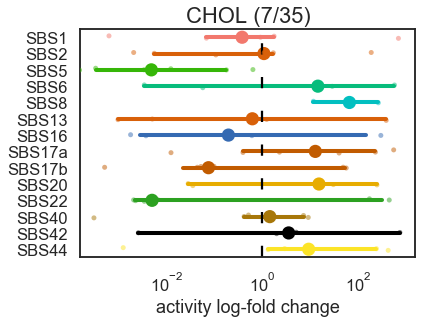

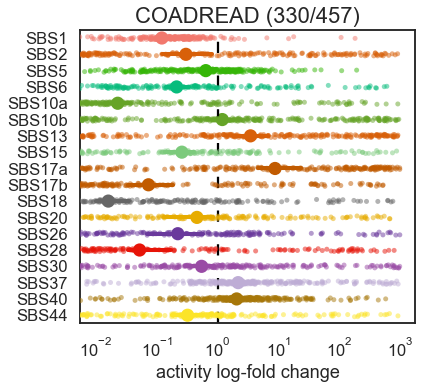

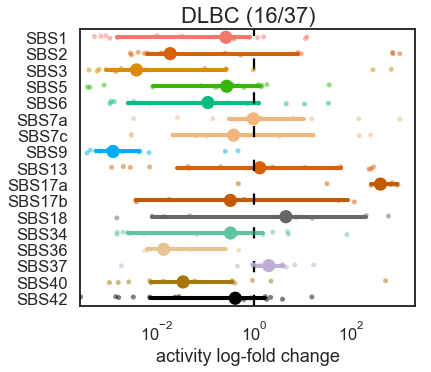

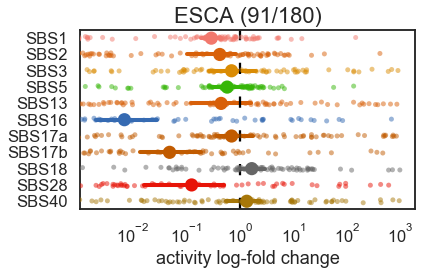

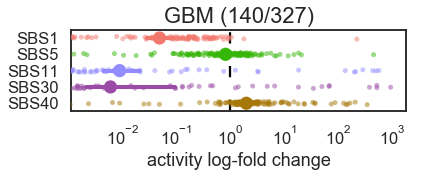

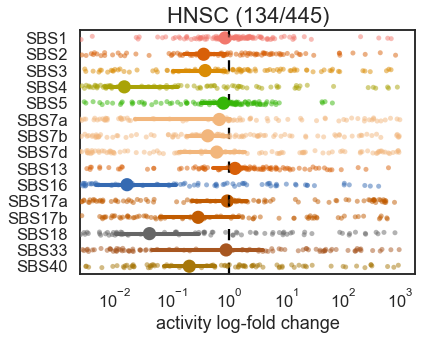

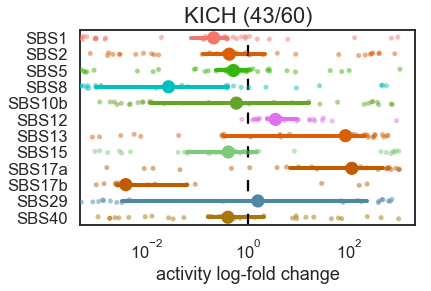

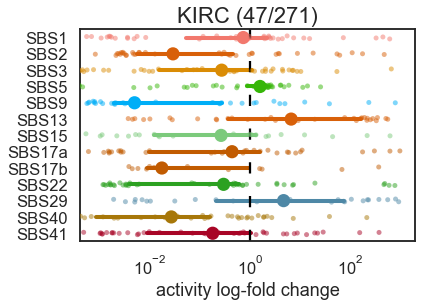

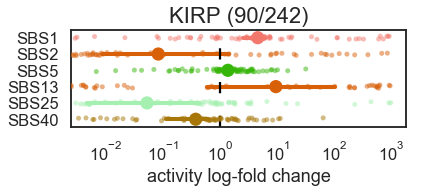

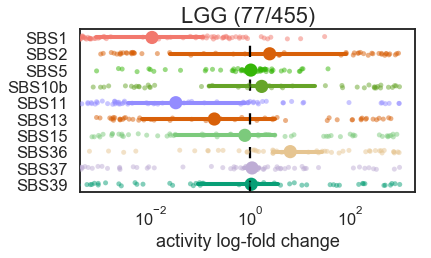

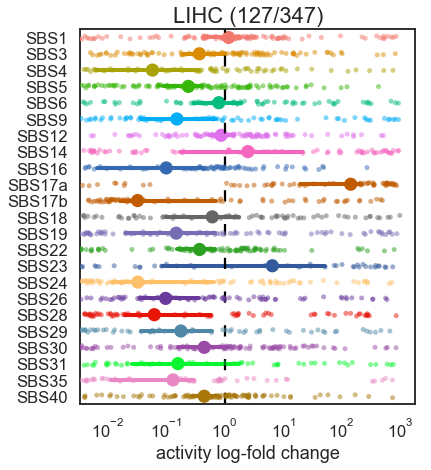

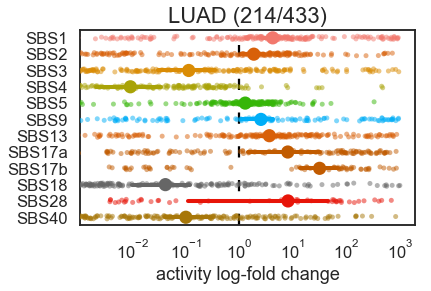

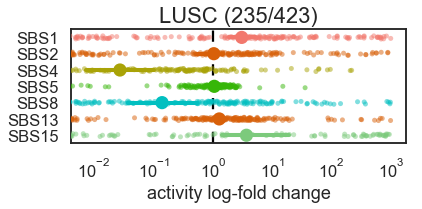

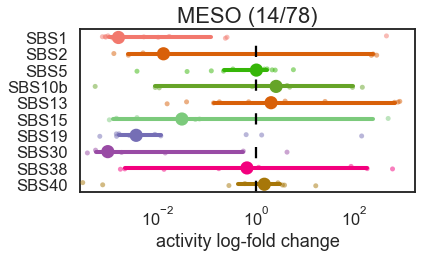

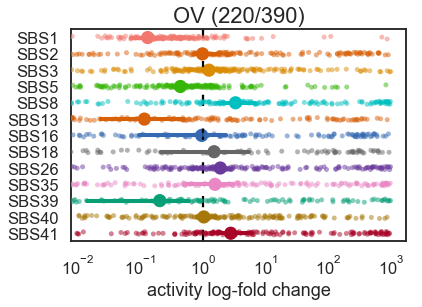

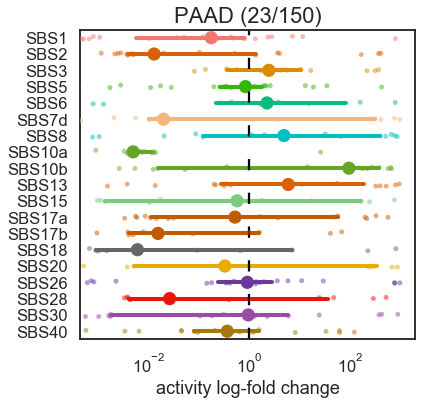

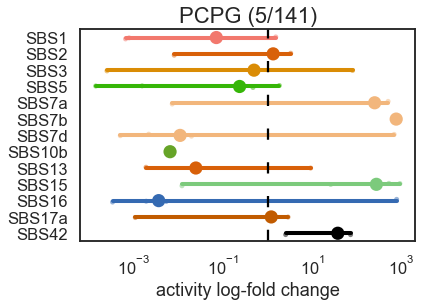

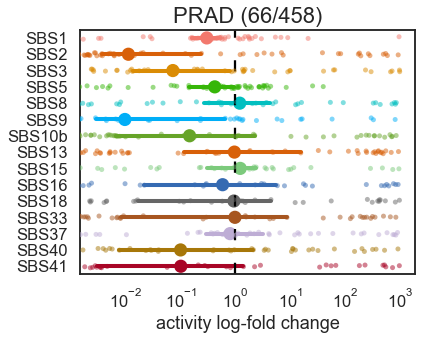

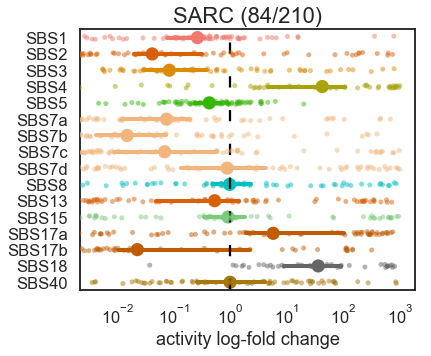

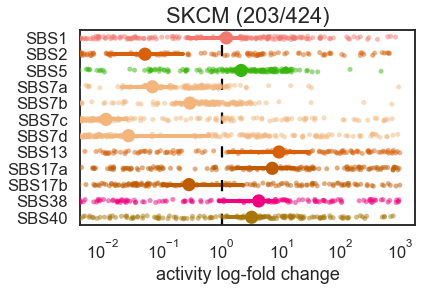

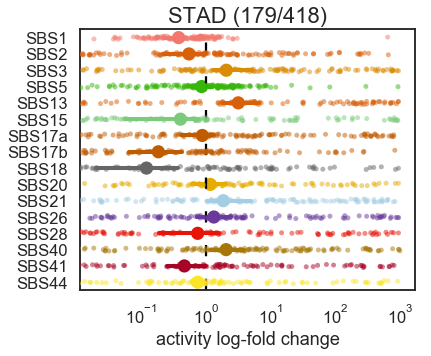

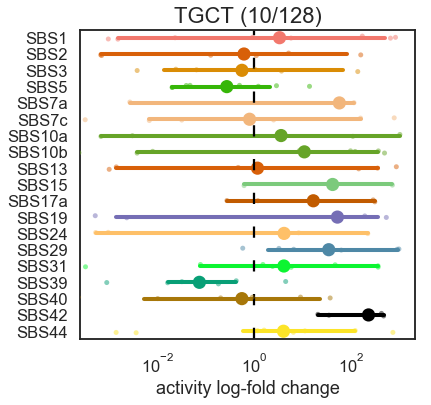

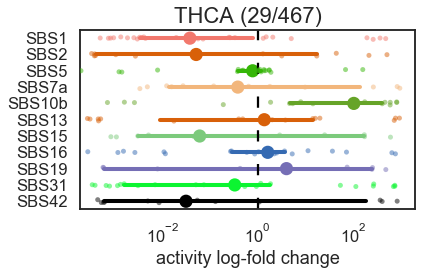

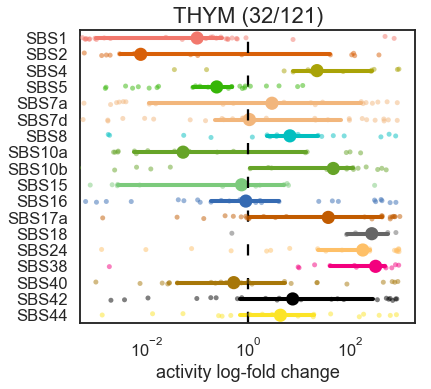

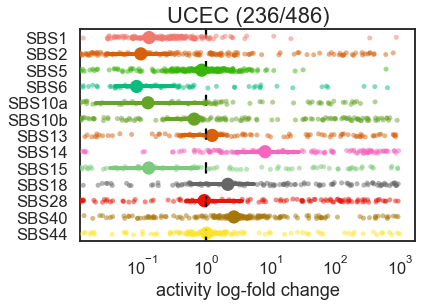

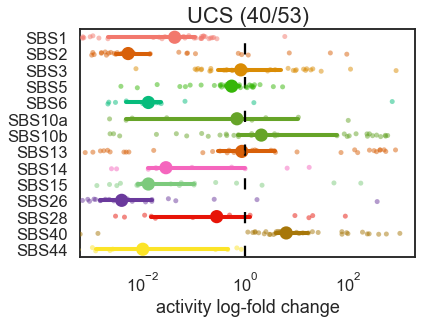

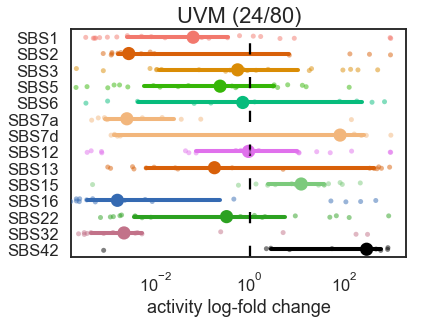

In [39]:


sns.set_style('white')
for loc in clonesig_res.cancer_loc_x.unique():
    print(loc)
    sub_protected_chg = clonesig_res[(clonesig_res.mutation_set=='protected')&(clonesig_res.pval<0.05) & (clonesig_res.cancer_loc_x==loc)]#&(clonesig_res.nb_mut>200)&(clonesig_res.purity>0.4)]
    sbs_names = [c.split('_')[1] for c in sub_protected_chg if 'subclonal_SBS' in c]
    for c in sub_protected_chg.columns:
        if 'subclonal_SBS' in c:
            sub_protected_chg = sub_protected_chg.assign(**{'{}_round'.format(c): sub_protected_chg.apply(lambda x: x[c] if x[c]>0.0001 else 0.0001 if x[c.replace("subclonal", "clonal")] > 0.0001 else 0, axis=1)})
        if ('clonal_SBS' in c) and ('subclonal_SBS' not in c):
            sub_protected_chg = sub_protected_chg.assign(**{'{}_round'.format(c): sub_protected_chg.apply(lambda x: x[c] if x[c]>0.0001 else 0.0001, axis=1)})
    bla = pd.DataFrame(sub_protected_chg[[c for c in sub_protected_chg if ('subclonal_SBS' in c) and  ('round' in c)]].fillna(0).values/sub_protected_chg[[c for c in sub_protected_chg if ('clonal_SBS' in c) and ("sub" not in c) and ("round" in c)]].fillna(0.001).values, columns=sbs_names)

    final_table = bla[[c for i, c in enumerate(bla.columns) if np.abs(bla).sum(axis=0)[c]>0]]
    m = pd.melt(final_table)
    m_filter = m[m.value<1000]
    mm = m_filter[m_filter.value>0].groupby('variable').count()
    m_filter_mean = pd.merge(m_filter, mm, on='variable', suffixes=['', '_nonzero'])
    final_m = m_filter_mean[m_filter_mean.value_nonzero>(len(sub_protected_chg)/10)]
    fig, ax = plt.subplots(figsize=(6, 0.3*final_m.variable.nunique()))
    sns.stripplot(y='variable', x='value', data=final_m, ax=ax, palette=[color_dict[c] for c in final_m.variable.unique()], alpha=0.5)
    sns.pointplot(y='variable', x='value', data=final_m[final_m.value>0], ax=ax, palette=[color_dict[c] for c in final_m.variable.unique()], estimator=np.median)
    ax.set_xscale("log")
    ax.set_ylabel('')
    ax.set_xlabel('activity log-fold change')
    #ax.set_xlim([0.01, 100])
    ax.set_title('{} ({}/{})'.format(sub_protected_chg.cancer_loc_x.unique()[0], len(sub_protected_chg), len(clonesig_res[(clonesig_res.mutation_set=='protected') & (clonesig_res.cancer_loc_x==loc)])), fontsize=22,y=1 + 0.05/final_table.shape[1])
    ax.axvline(x=1, ls=(0, (5, 10)), color='black')
    plt.savefig('{}/{}_sig_trend_new.pdf'.format(output_path, loc), bbox_inches='tight')

In [40]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]

clonesig_res_all_protected.loc[clonesig_res_all_protected.SEX=='MALE', 'SEX'] = 'Male'
clonesig_res_all_protected.SEX.value_counts(dropna=False)
clonesig_res_all_protected = clonesig_res_all_protected.assign(sig_change=(clonesig_res_all_protected.pval<0.05).astype(int))


clonesig_res_all_protected = clonesig_res_all_protected.assign(group='oneClone')

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05), 'group'] = 'twoClonesNochange'
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05), 'group'] = 'twoClonesChange'



In [41]:
clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'sig_change', 'nb_clones', 'AGE', 'SEX', 'stage', 'cancer_loc_x', 'group']].dropna(subset=['binary_vital_status_15y', 'survival_months_15y', 'sig_change', 'nb_clones', 'cancer_loc_x', 'group'], how='any').to_csv('20200519_tcga_surv.csv', sep='\t', index=False)



In [42]:
sample_list = ['TCGA-3B-A9HI', 'TCGA-3B-A9HT', 'TCGA-04-1341', 'TCGA-18-4721',
               'TCGA-19-2629', 'TCGA-20-0990', 'TCGA-20-1685']
for s in sample_list:
    print('cp 20200519_tcga_plots/{}_protected_clonesig_global.pdf 20200515_paper_figures/tcga_examples'.format(s))

cp 20200519_tcga_plots/TCGA-3B-A9HI_protected_clonesig_global.pdf 20200515_paper_figures/tcga_examples
cp 20200519_tcga_plots/TCGA-3B-A9HT_protected_clonesig_global.pdf 20200515_paper_figures/tcga_examples
cp 20200519_tcga_plots/TCGA-04-1341_protected_clonesig_global.pdf 20200515_paper_figures/tcga_examples
cp 20200519_tcga_plots/TCGA-18-4721_protected_clonesig_global.pdf 20200515_paper_figures/tcga_examples
cp 20200519_tcga_plots/TCGA-19-2629_protected_clonesig_global.pdf 20200515_paper_figures/tcga_examples
cp 20200519_tcga_plots/TCGA-20-0990_protected_clonesig_global.pdf 20200515_paper_figures/tcga_examples
cp 20200519_tcga_plots/TCGA-20-1685_protected_clonesig_global.pdf 20200515_paper_figures/tcga_examples


In [43]:
for i, s in enumerate(sample_list):
    nb_snv = clonesig_res[(clonesig_res.mutation_set=='protected')&(clonesig_res.patient_id==s)].nb_mut.values[0]
    loc = clonesig_res[(clonesig_res.mutation_set=='protected')&(clonesig_res.patient_id==s)].cancer_loc_x.values[0]
    print('\\begin{{figure}}[htb!]\n\includegraphics[width=\\textwidth]{{20200515_paper_figures/tcga_examples/{}_protected_clonesig_global.pdf}}\n\caption{{\\textbf{{CloneSig analysis of {} SNVs obtained by WES of a {} sample (patient {})}}}}\n\label{{fig:example_tcga{}}}\n\end{{figure}}'.format(s, nb_snv, loc, s, i))
    
    
    

\begin{figure}[htb!]
\includegraphics[width=\textwidth]{20200515_paper_figures/tcga_examples/TCGA-3B-A9HI_protected_clonesig_global.pdf}
\caption{\textbf{CloneSig analysis of 246 SNVs obtained by WES of a SARC sample (patient TCGA-3B-A9HI)}}
\label{fig:example_tcga0}
\end{figure}
\begin{figure}[htb!]
\includegraphics[width=\textwidth]{20200515_paper_figures/tcga_examples/TCGA-3B-A9HT_protected_clonesig_global.pdf}
\caption{\textbf{CloneSig analysis of 1002 SNVs obtained by WES of a SARC sample (patient TCGA-3B-A9HT)}}
\label{fig:example_tcga1}
\end{figure}
\begin{figure}[htb!]
\includegraphics[width=\textwidth]{20200515_paper_figures/tcga_examples/TCGA-04-1341_protected_clonesig_global.pdf}
\caption{\textbf{CloneSig analysis of 221 SNVs obtained by WES of a OV sample (patient TCGA-04-1341)}}
\label{fig:example_tcga2}
\end{figure}
\begin{figure}[htb!]
\includegraphics[width=\textwidth]{20200515_paper_figures/tcga_examples/TCGA-18-4721_protected_clonesig_global.pdf}
\caption{\textbf{Clon

In [44]:
sum(clonesig_res[clonesig_res.mutation_set=='protected'].pval<0.05) / clonesig_res[clonesig_res.mutation_set=='protected'].patient_id.nunique()


0.38576695341302647

In [45]:
clonesig_res.patient_id.nunique()

8951

In [46]:
sum(clonesig_res[clonesig_res.mutation_set=='public'].pval<0.05) / clonesig_res[clonesig_res.mutation_set=='public'].patient_id.nunique()


0.14445313372807508